<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%reset -f

In [4]:
pip install pycoingecko

In [96]:
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

from sklearn.model_selection import train_test_split, GridSearchCV

from IPython import display

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, BatchNormalization, Conv2D, Conv1D
from keras.layers import Bidirectional, AveragePooling1D, Flatten, TimeDistributed, AveragePooling2D, AveragePooling2D
from keras.layers import Lambda

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [7]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [8]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes','market_caps']]
    return df

In [9]:
#dd/mm/yyyy
from_date = "01/01/2019"
to_date = "31/01/2022"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [10]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(1127, 3)


,prices,total_volumes,market_caps
dates,,,
2022-01-27,36870.440167,2.675687e+10,7.001658e+11
2022-01-28,37276.839558,2.205741e+10,7.023115e+11
2022-01-29,37852.579028,1.921410e+10,7.170269e+11
2022-01-30,38232.178732,1.417865e+10,7.228290e+11
2022-01-31,37983.151499,1.180719e+10,7.195701e+11


In [11]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
values_ma = [5,10,15,30]

for i in values_ma:
    df["ma_close_" + str(i)] = df["prices"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,10,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,10,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

In [12]:
df.tail(5)

,prices,total_volumes,market_caps,ma_close_5,ma_close_10,ma_close_15,ma_close_30,ema_5,ema_10,ema_15,ema_30,rsi_sma_7,rsi_sma_10,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
dates,,,,,,,,,,,,,,,,,,,,,
2022-01-27,36870.440167,2.675687e+10,7.001658e+11,36424.044145,38578.005427,40122.509235,42463.688410,37133.593372,38314.798457,39412.441992,42049.521103,21.286162,18.941373,20.756823,29.751403,37907.701225,34940.387064,44261.848895,32894.161958,46363.269847,34799.823049
2022-01-28,37276.839558,2.205741e+10,7.023115e+11,36843.324964,38075.855271,39675.506717,42115.411460,37181.342101,38126.078657,39145.491688,41741.606165,28.177043,23.969778,26.181484,32.226799,37552.517300,36134.132627,43153.880236,32997.830306,46314.537300,34423.519847
2022-01-29,37852.579028,1.921410e+10,7.170269e+11,37152.558881,37621.567294,39358.451318,41826.930939,37405.087743,38076.351452,38983.877605,41490.701188,65.855860,27.564128,26.596606,38.219326,38021.547477,36283.570286,41695.678596,33547.455993,46183.518318,34164.130500
2022-01-30,38232.178732,1.417865e+10,7.228290e+11,37444.193199,37269.830025,39032.539600,41528.274618,37680.784739,38104.683685,38889.915246,41280.473933,96.397129,32.159509,28.339848,38.808387,38607.019887,36281.366512,40209.351055,34330.308994,46006.560144,33978.070449
2022-01-31,37983.151499,1.180719e+10,7.195701e+11,37643.037797,36997.376933,38682.973015,41250.391298,37781.573659,38082.586924,38776.569778,41067.743453,84.761603,34.972241,27.994639,37.793106,38755.548537,36530.527056,38809.613777,35185.140089,45807.956956,33788.002881


In [123]:
columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]

df_rs = np.array(df[columns])
df_rs.shape

(1127, 7)

In [124]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [125]:
past_t = 60
forecast_t = 2
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[0], columns=columns)

Shape X --> (1066, 60, 7)
Shape y --> (1066, 2)
Example of day -->


,prices,total_volumes,market_caps,ema_5,ema_10,ema_15,ema_30
0,3692.531566,2.991428e+09,6.442264e+10,3692.531566,3692.531566,3692.531566,3692.531566
1,3794.264254,2.689878e+09,6.618845e+10,3726.442462,3711.028418,3705.248152,3699.094965
2,3872.172184,3.263469e+09,6.764330e+10,3775.019036,3740.327285,3726.113656,3710.261237
3,3776.525808,2.261200e+09,6.592229e+10,3775.521293,3746.908834,3732.415175,3714.536371
4,3815.268080,2.950055e+09,6.665077e+10,3788.770222,3759.337788,3742.771788,3721.035191
5,3787.307857,2.763832e+09,6.607097e+10,3788.282767,3764.423255,3748.338796,3725.310846
6,4013.520091,3.435733e+09,7.008417e+10,3863.361875,3809.713589,3781.486458,3743.904991
7,3989.668718,3.360164e+09,6.960213e+10,3905.464156,3842.432703,3807.509241,3759.760716
8,3973.591255,3.482431e+09,6.941869e+10,3928.173189,3866.279713,3828.269492,3773.556234
9,3982.225913,3.230523e+09,6.960928e+10,3946.190763,3887.360840,3847.514045,3787.018794


In [126]:
test_size = 200
train_size = len(X) - test_size
X_train = X[0:train_size]
y_train = y[0:train_size]
X_test = X[train_size:len(X)]
y_test = y[train_size:len(X)]
print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))

Shape X_train --> (866, 60, 7)
Shape y_train --> (866, 2)
Shape X_test  --> (200, 60, 7)
Shape y_test  --> (200, 2)


In [127]:
X[0][0:4]

array([[3.69253157e+03, 2.99142757e+09, 6.44226356e+10, 3.69253157e+03,
        3.69253157e+03, 3.69253157e+03, 3.69253157e+03],
       [3.79426425e+03, 2.68987785e+09, 6.61884489e+10, 3.72644246e+03,
        3.71102842e+03, 3.70524815e+03, 3.69909496e+03],
       [3.87217218e+03, 3.26346904e+09, 6.76433050e+10, 3.77501904e+03,
        3.74032728e+03, 3.72611366e+03, 3.71026124e+03],
       [3.77652581e+03, 2.26119975e+09, 6.59222886e+10, 3.77552129e+03,
        3.74690883e+03, 3.73241517e+03, 3.71453637e+03]])

In [128]:
X_train[0][0:4]

array([[3.69253157e+03, 2.99142757e+09, 6.44226356e+10, 3.69253157e+03,
        3.69253157e+03, 3.69253157e+03, 3.69253157e+03],
       [3.79426425e+03, 2.68987785e+09, 6.61884489e+10, 3.72644246e+03,
        3.71102842e+03, 3.70524815e+03, 3.69909496e+03],
       [3.87217218e+03, 3.26346904e+09, 6.76433050e+10, 3.77501904e+03,
        3.74032728e+03, 3.72611366e+03, 3.71026124e+03],
       [3.77652581e+03, 2.26119975e+09, 6.59222886e+10, 3.77552129e+03,
        3.74690883e+03, 3.73241517e+03, 3.71453637e+03]])

In [129]:
from tensorflow.keras.optimizers import Adam, Adadelta # - Works 
from tensorflow.keras import layers

In [130]:
inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN 1
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# GRU + GRU
x = layers.GRU(16)(x)
x = layers.BatchNormalization()(x)

# FNN
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output layer, 1 neuron with sigmoid:
predictions = layers.Dense(y_train.shape[1], activation="relu", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['mean_squared_error'])

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 60, 7)]           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 60, 32)            704       
                                                                 
 batch_normalization_29 (Bat  (None, 60, 32)           128       
 chNormalization)                                                
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 30, 32)           0         
 g1D)                                                            
                                                                 
 gru_11 (GRU)                (None, 16)                2400      
                                                                 
 batch_normalization_30 (Bat  (None, 16)               64  

In [131]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=2.5e-5)
checkpoint = keras.callbacks.ModelCheckpoint('backup/modelo_prueba{epoch:08d}.h5', save_freq = 10) 

In [ ]:
history = model.fit(X_train, y_train, epochs = 100, batch_size = 4, 
                    validation_data= (X_test, y_test))

Epoch 1/100
217/217 [==============================] - 7s 16ms/step - loss: 564255680.0000 - mean_squared_error: 564255680.0000 - val_loss: 2468200192.0000 - val_mean_squared_error: 2468200192.0000
Epoch 2/100
217/217 [==============================] - 3s 12ms/step - loss: 564195200.0000 - mean_squared_error: 564195200.0000 - val_loss: 2467620352.0000 - val_mean_squared_error: 2467620352.0000
Epoch 3/100
217/217 [==============================] - 3s 12ms/step - loss: 564087872.0000 - mean_squared_error: 564087872.0000 - val_loss: 2466668800.0000 - val_mean_squared_error: 2466668800.0000
Epoch 4/100
217/217 [==============================] - 3s 12ms/step - loss: 563939072.0000 - mean_squared_error: 563939072.0000 - val_loss: 2466236416.0000 - val_mean_squared_error: 2466236416.0000
Epoch 5/100
217/217 [==============================] - 3s 13ms/step - loss: 563744064.0000 - mean_squared_error: 563744064.0000 - val_loss: 2465385728.0000 - val_mean_squared_error: 2465385728.0000
Epoch 6/10

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

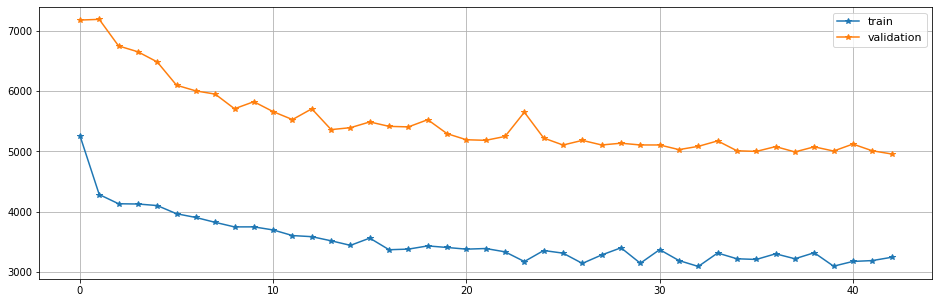

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [ ]:
y_pred_redes = model.predict(X_test, verbose=1)

7/7 [==============================] - 0s 2ms/step


In [ ]:
#y_test_original = y_test * (maximo - minimo) + minimo
#y_pred_redes_ok = y_pred_redes * (maximo - minimo) + minimo
#y_pred_baseline_ok = y_pred_baseline * (maximo - minimo) + minimo

y_test_original = y_test 
y_pred_redes_ok = y_pred_redes 
#y_pred_baseline_ok = y_pred_baseline 

In [ ]:
errores_redes = np.empty([len(y_test_original)])
#errores_baseline = np.empty([len(y_test_original)])
for i in range(0,len(y_test_original)):
    errores_redes[i] = np.linalg.norm(y_test_original[i] - y_pred_redes_ok[i], np.inf)
    #errores_baseline[i] = np.linalg.norm(y_test_original[i] - y_pred_baseline_ok[i], np.inf)

In [ ]:
print("Errores usando Redes")
print(pd.DataFrame(errores_redes).describe().transpose().round(2))
# print("Errores usando Baseline")
# print(pd.DataFrame(errores_baseline).describe().transpose().round(2))

Errores usando Redes
   count     mean      std     min      25%      50%      75%       max
0  200.0  9912.95  6855.45  238.95  3803.92  9323.72  15183.0  30296.06


In [ ]:
#s1 = errores_baseline[errores_baseline < np.percentile(errores_baseline, 95)]
s2 = errores_redes[errores_redes < np.percentile(errores_redes, 95)]

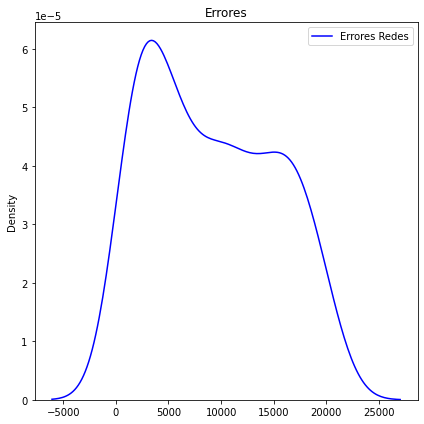

In [ ]:
plt.figure(figsize=(6,6))
#sns.kdeplot(s1, color = "red",  label = 'Errores Baseline')
sns.kdeplot(s2, color = "blue", label = 'Errores Redes')
plt.title('Errores')
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# best_baseline = np.argmin(errores_baseline)
# worse_baseline = np.argmax(errores_baseline)
# print("Posicion mejor Baseline Model: " + str(best_baseline))
# print("Posicion peor Baseline Model: " + str(worse_baseline))

best_redes = np.argmin(errores_redes)
worse_redes = np.argmax(errores_redes)
print("Posicion mejor Redes Model: " + str(best_redes))
print("Posicion peor Redes Model: " + str(worse_redes))

Posicion mejor Redes Model: 58
Posicion peor Redes Model: 108


<Figure size 1440x432 with 0 Axes>

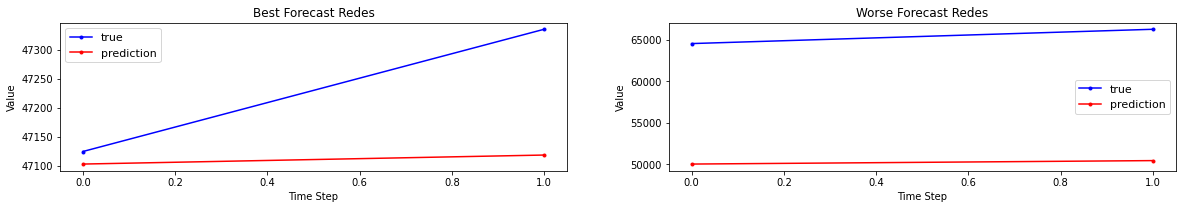

In [ ]:
plt.figure(figsize=(20, 6))
#plt.subplot(111)
# plt.title("Best Forecast Baseline")
# plt.plot(y_test[best_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[best_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

# plt.subplot(222)
# plt.title("Worse Forecast Baseline")
# plt.plot(y_test[worse_baseline], color = "blue", marker='.', label="true")
# plt.plot(y_pred_baseline[worse_baseline], color = 'red', marker = ".", label="prediction")
# plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Redes")
plt.plot(y_test[best_redes],  color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[best_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Redes")
plt.plot(y_test[worse_redes], color = "blue", marker='.', label="true")
plt.plot(y_pred_redes[worse_redes][0], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();